# k-means clustering for radar data

The commands for the k-means clustering part of this are loosely based on code posted here: https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python

In [2]:
import cv2
import rasterio as rast
from rasterio.plot import show
from rasterio.transform import Affine
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import os

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    pl.ion()

Reading in a raster.

In [51]:
indir1 = "/home/devingoodsman/Desktop/MPB Doppler/July262005Brasters/200507261500~~DOPVOL1_B:URP:XPG:RADAR:IRIS"
r1 = rast.open(indir1)
dBZ1 = r1.read(1)
Vel1 = r1.read(2)
Width1 = r1.read(3)
r1.crs
r1.close()

Rasterio has a bug where the raster appears to be flipped relative to how it should look (https://github.com/rasterio/rasterio/issues/1683). This can be seen by calling r1.bounds() below. This problem can be fixed with an affine transformation and a flip of the data.

(-223.56117988750339, -224.7278589408379)
BoundingBox(left=1312753.402709891, bottom=1073133.664713414, right=1089192.2228223877, top=848405.8057725761)


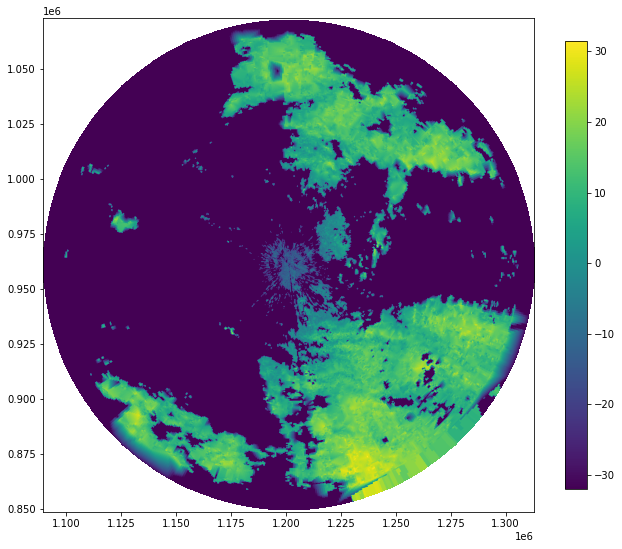

In [52]:
# plotting the raster
print(r1.res)
print(r1.bounds)
resx = r1.res[0]
resy = r1.res[1]
x0 = r1.bounds[2]
y0 = r1.bounds[1]
transform1 = Affine.translation(x0 - resx / 2, y0 - resy / 2) * Affine.scale(-resx, resy)
fig, ax = pl.subplots(figsize=(11, 11))
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(dBZ1))

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(dBZ1), transform=transform1, ax=ax)
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

The other two bands of the raster can be plotted as follows:

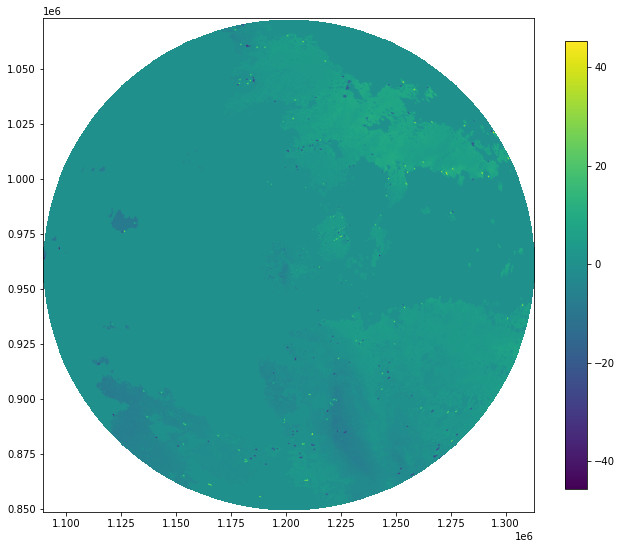

In [54]:
fig, ax = pl.subplots(figsize=(11, 11))
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(Vel1))

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(Vel1), transform=transform1, ax=ax)
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

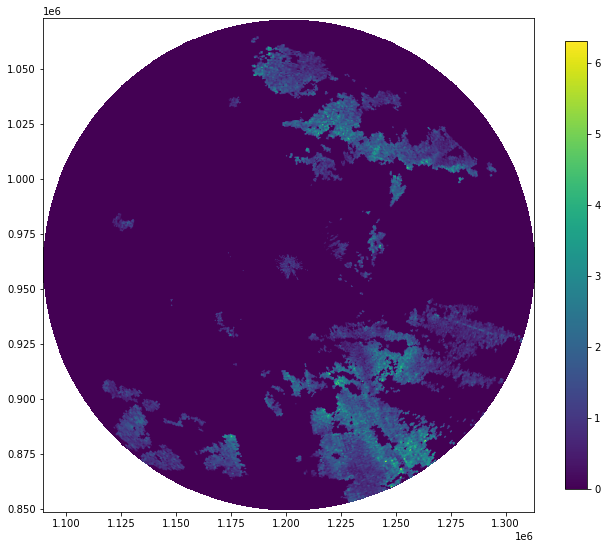

In [55]:
fig, ax = pl.subplots(figsize=(11, 11))
# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(np.flip(Width1))

# plot on the same axis with rast.plot.show
im = rast.plot.show(np.flip(Width1), transform=transform1, ax=ax)
fig.colorbar(image_hidden, ax=ax, shrink = 0.75)

## Trying the clustering algorithm

First I need to flatten the arrays and reassemble them into a 1000000 by 3 array of floating point numbers.

In [56]:
dBZ1flat = np.reshape(dBZ1, (1000000,1))
Velflat = np.reshape(Vel1, (1000000,1))
Widthflat = np.reshape(Width1, (1000000,1))

print(dBZ1.min())

inarray = np.hstack((dBZ1flat, Velflat, Widthflat))
inarray.shape

nan


(1000000, 3)

Note that the nan values will need to be converted to some value. I think we can convert them to -999.9. In addition the kmeans function in opencv needs the array to be of float type 32.

In [57]:
inarray = np.nan_to_num(inarray, copy = False, nan = -999.9)
print(inarray.min())
inarray = np.float32(inarray)

-999.9


Now we can run the k-means clustering algorithm.

In [81]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.2)

# number of clusters (K)
k = 4
_, labels, (centers) = cv2.kmeans(inarray, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

Now to reassamble the labels so that they are in the shape of the original image.

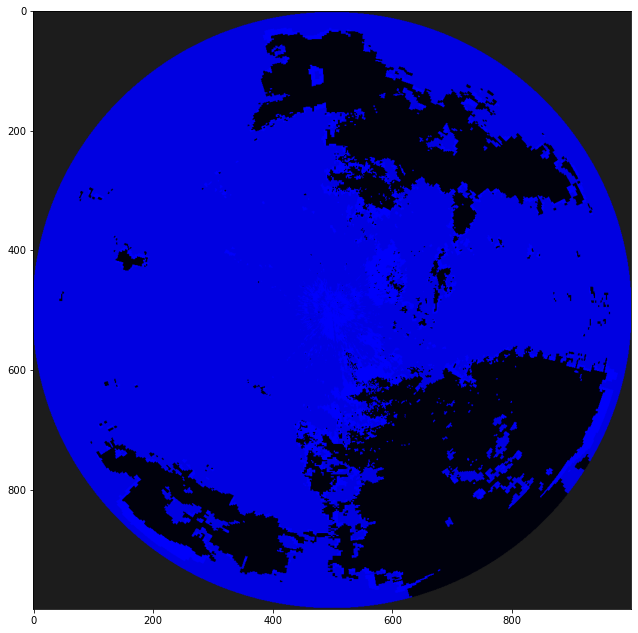

In [85]:
# convert back to 8 bit values
centers = np.uint8(centers)

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape((1000, 1000, 3))
# show the image
fig, ax = pl.subplots(figsize=(11, 11))
pl.imshow(np.flip(segmented_image))
pl.show()

Viewing pixels with each label:

In [86]:
print(np.unique(segmented_image))

[  0   1  12  28 225 251]


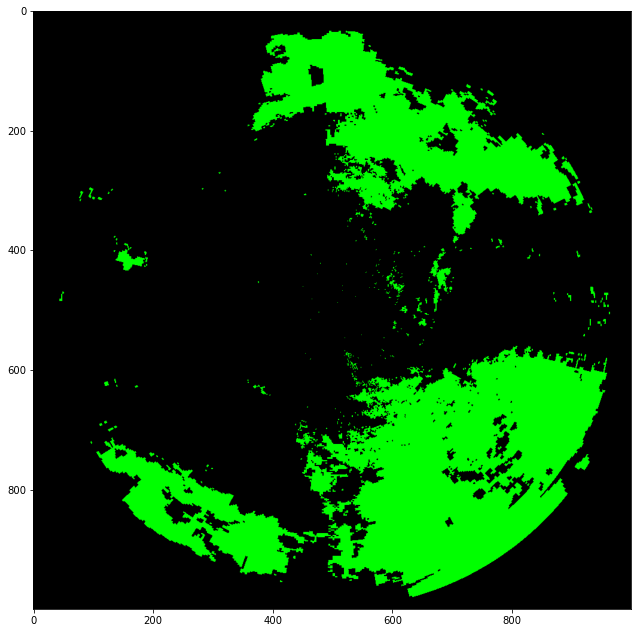

In [87]:
masked_image = np.zeros(segmented_image.shape)
cluster = 1
masked_image[segmented_image == cluster] = 1
# show the image
fig, ax = pl.subplots(figsize=(11, 11))
pl.imshow(np.flip(masked_image))
pl.show()

Now looking at the other classifications.

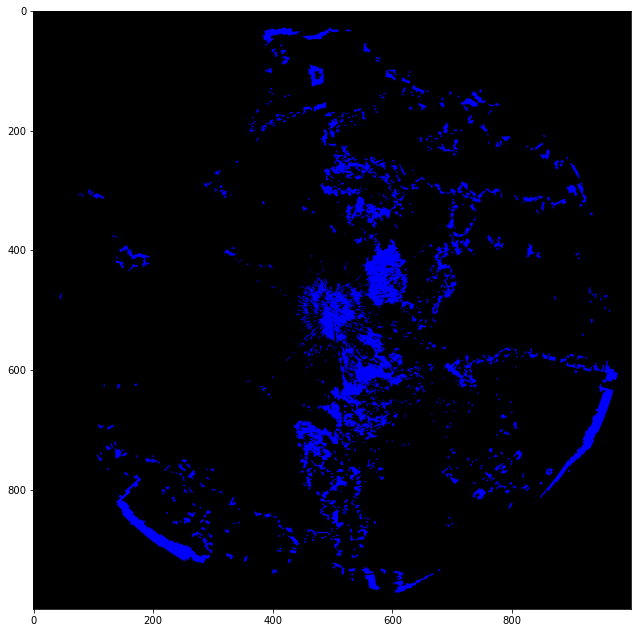

In [88]:
masked_image = np.zeros(segmented_image.shape)
cluster = 251
masked_image[segmented_image == cluster] = 1
# show the image
fig, ax = pl.subplots(figsize=(11, 11))
pl.imshow(np.flip(masked_image))
pl.show()